In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import gc
import collections
import statsmodels.api as sm
import scipy
import xarray as xr

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [3]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [4]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
cise_file_path = 'cise_data/'
reconstructions_neofs_path = 'reconstructions_neofs/'
std_file_path = 'standardized_rec_data/'

## Data input (pre-processed)

In [5]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
flux_ts = flux.sum(['x','y'])

In [13]:
flux_ts_demeaned = flux_ts - flux_ts.mean('time')

In [6]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

In [7]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

In [19]:
flux_dedraft_ts = flux_dedraft.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

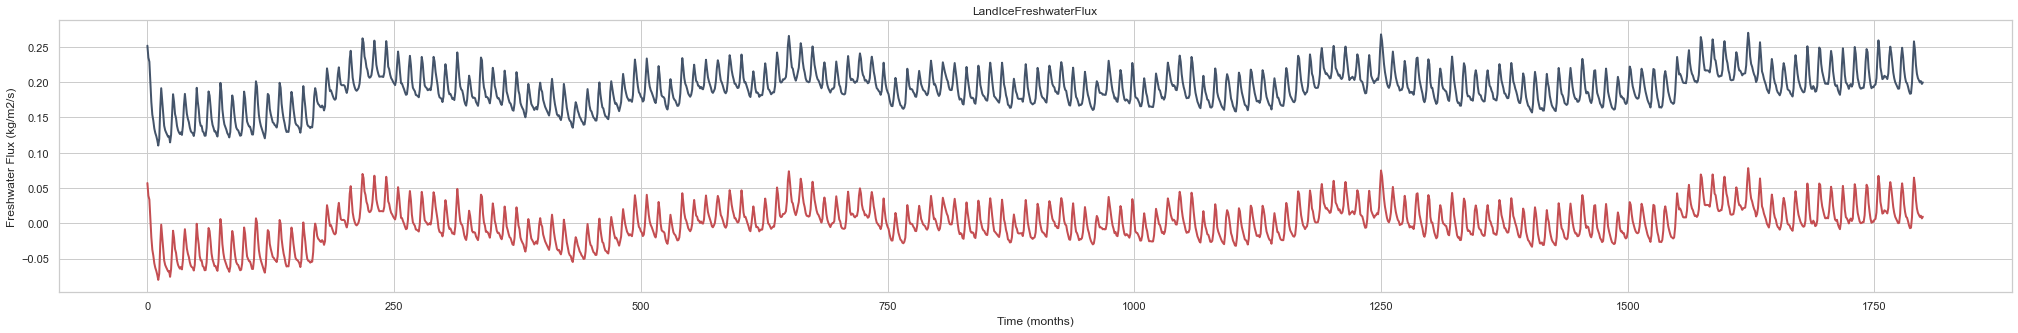

In [20]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, color = '#44546A', linewidth=2)
plt.plot(flux_dedraft_ts, color = 'r', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

Text(0.5, 0, 'Time (months)')

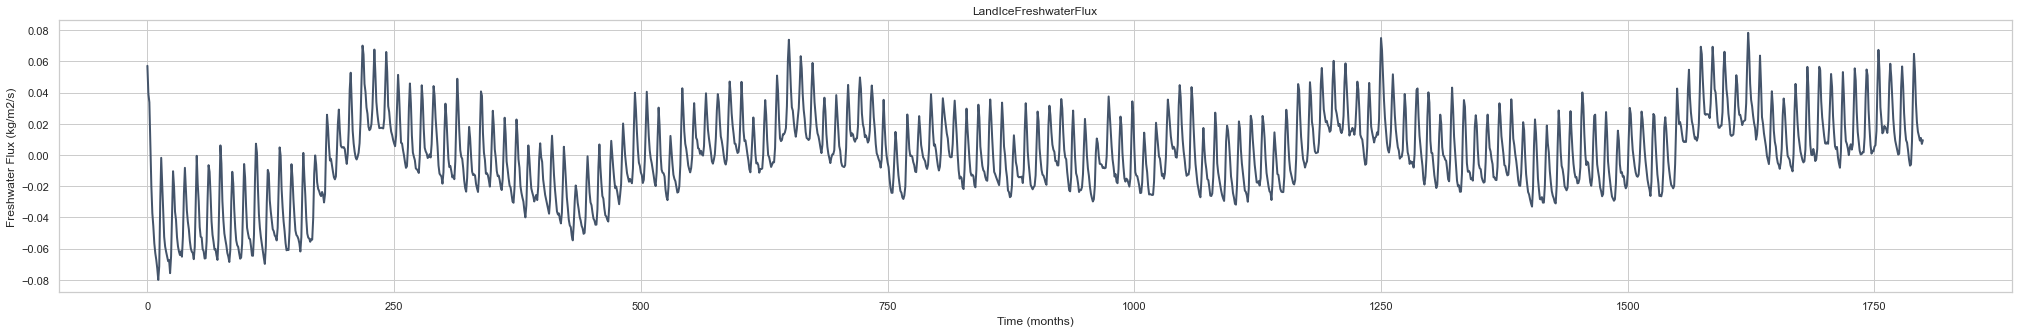

In [21]:
plt.figure(figsize=(35,5))
plt.plot(flux_dedraft_ts, color = '#44546A', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [8]:
# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [23]:
flux_dedraft_demeaned_ts = flux_dedraft_demeaned.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

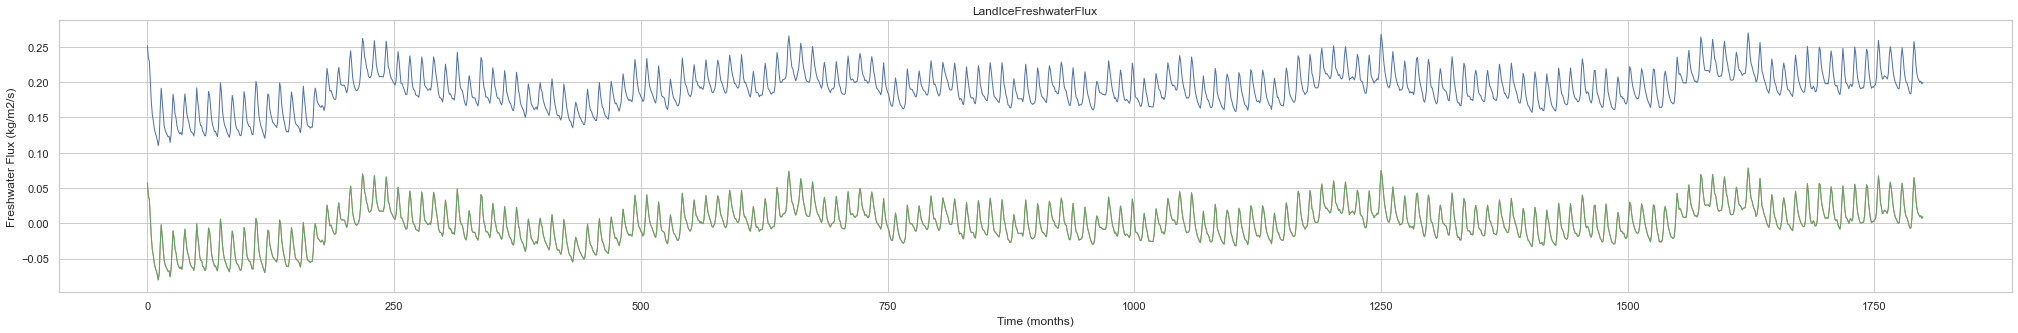

In [24]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, linewidth=1)
plt.plot(flux_dedraft_ts, linewidth=1)
plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [9]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [26]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [27]:
flux_month_ts = flux_month.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

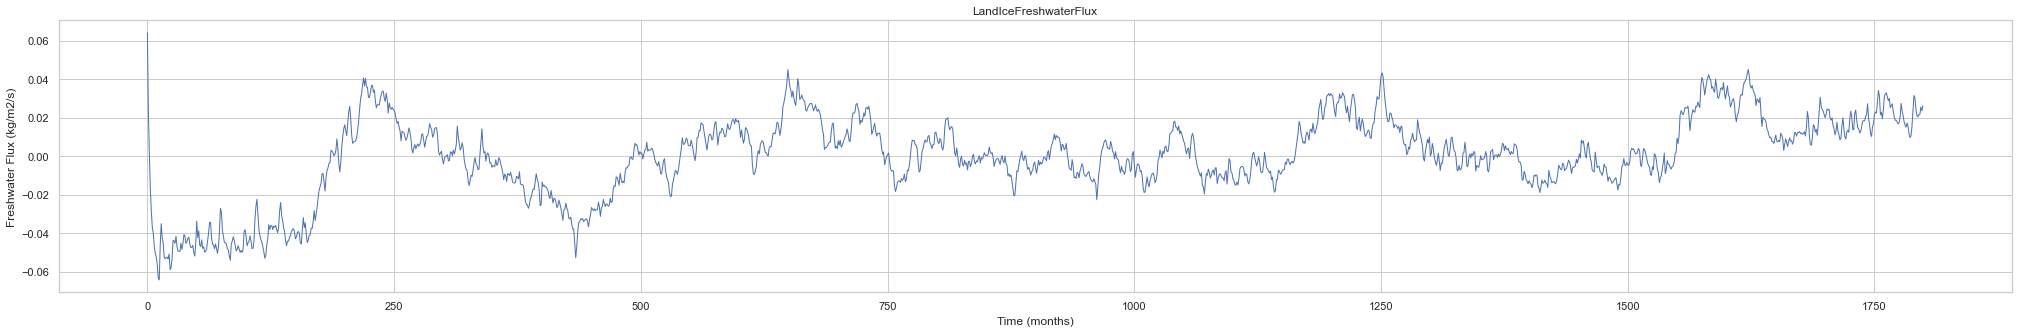

In [29]:
plt.figure(figsize=(35,5))
#plt.plot(flux_ts, linewidth=1)
#plt.plot(flux_dedraft_ts, linewidth=1)
#plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
#plt.plot(flux_month_ts, linewidth=1)
plt.plot(flux_anm_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [17]:
# Remove initial 'model spinup period' data before analysis

spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
flux_clean = flux_anm[spinup_time_period:]

## Processed/Clean Data Input

In [6]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [7]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

## Data Standardization

In [8]:
flux_clean_demeaned = flux_clean - flux_clean_tmean
flux_clean_standardized = flux_clean_demeaned/flux_clean_tstd

In [9]:
flux_clean_ts = flux_clean.sum(['x','y'])
#flux_clean_demeaned_ts = flux_clean_demeaned.sum(['x','y'])
flux_clean_standardized_ts = flux_clean_standardized.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

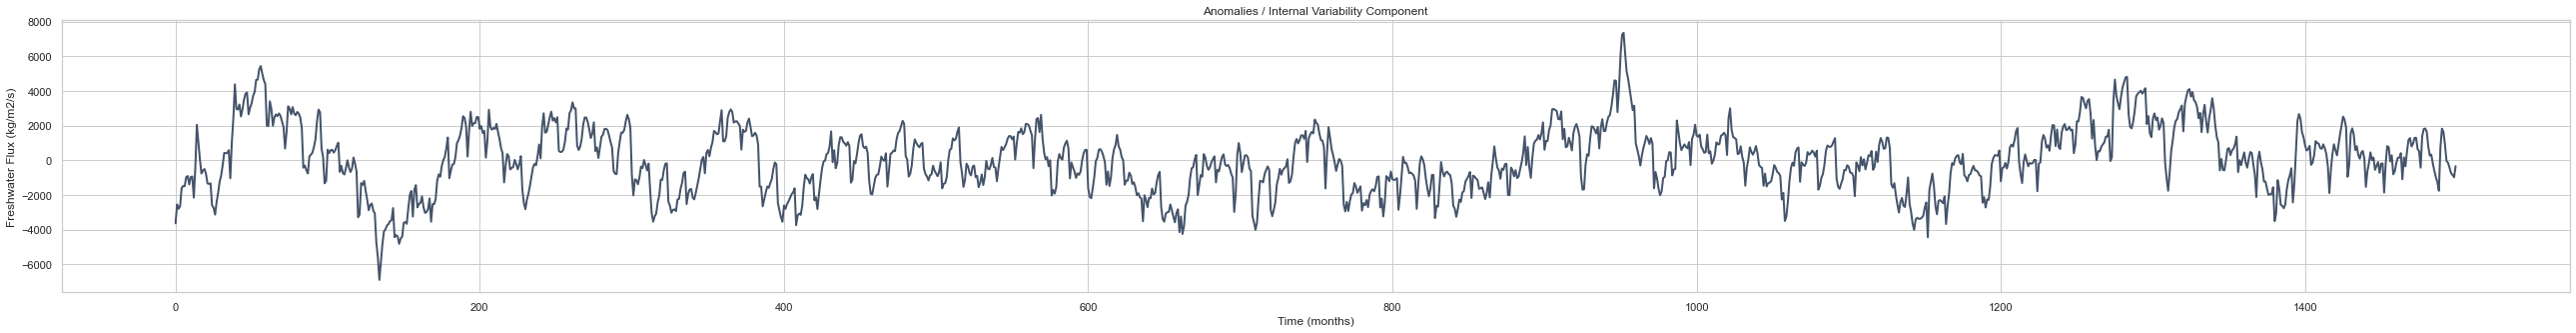

In [10]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
#plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOF

In [11]:
%%time
model = EOF(flux_clean_standardized)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 54.7 s, sys: 23.3 s, total: 1min 18s
Wall time: 26.3 s


## Figures

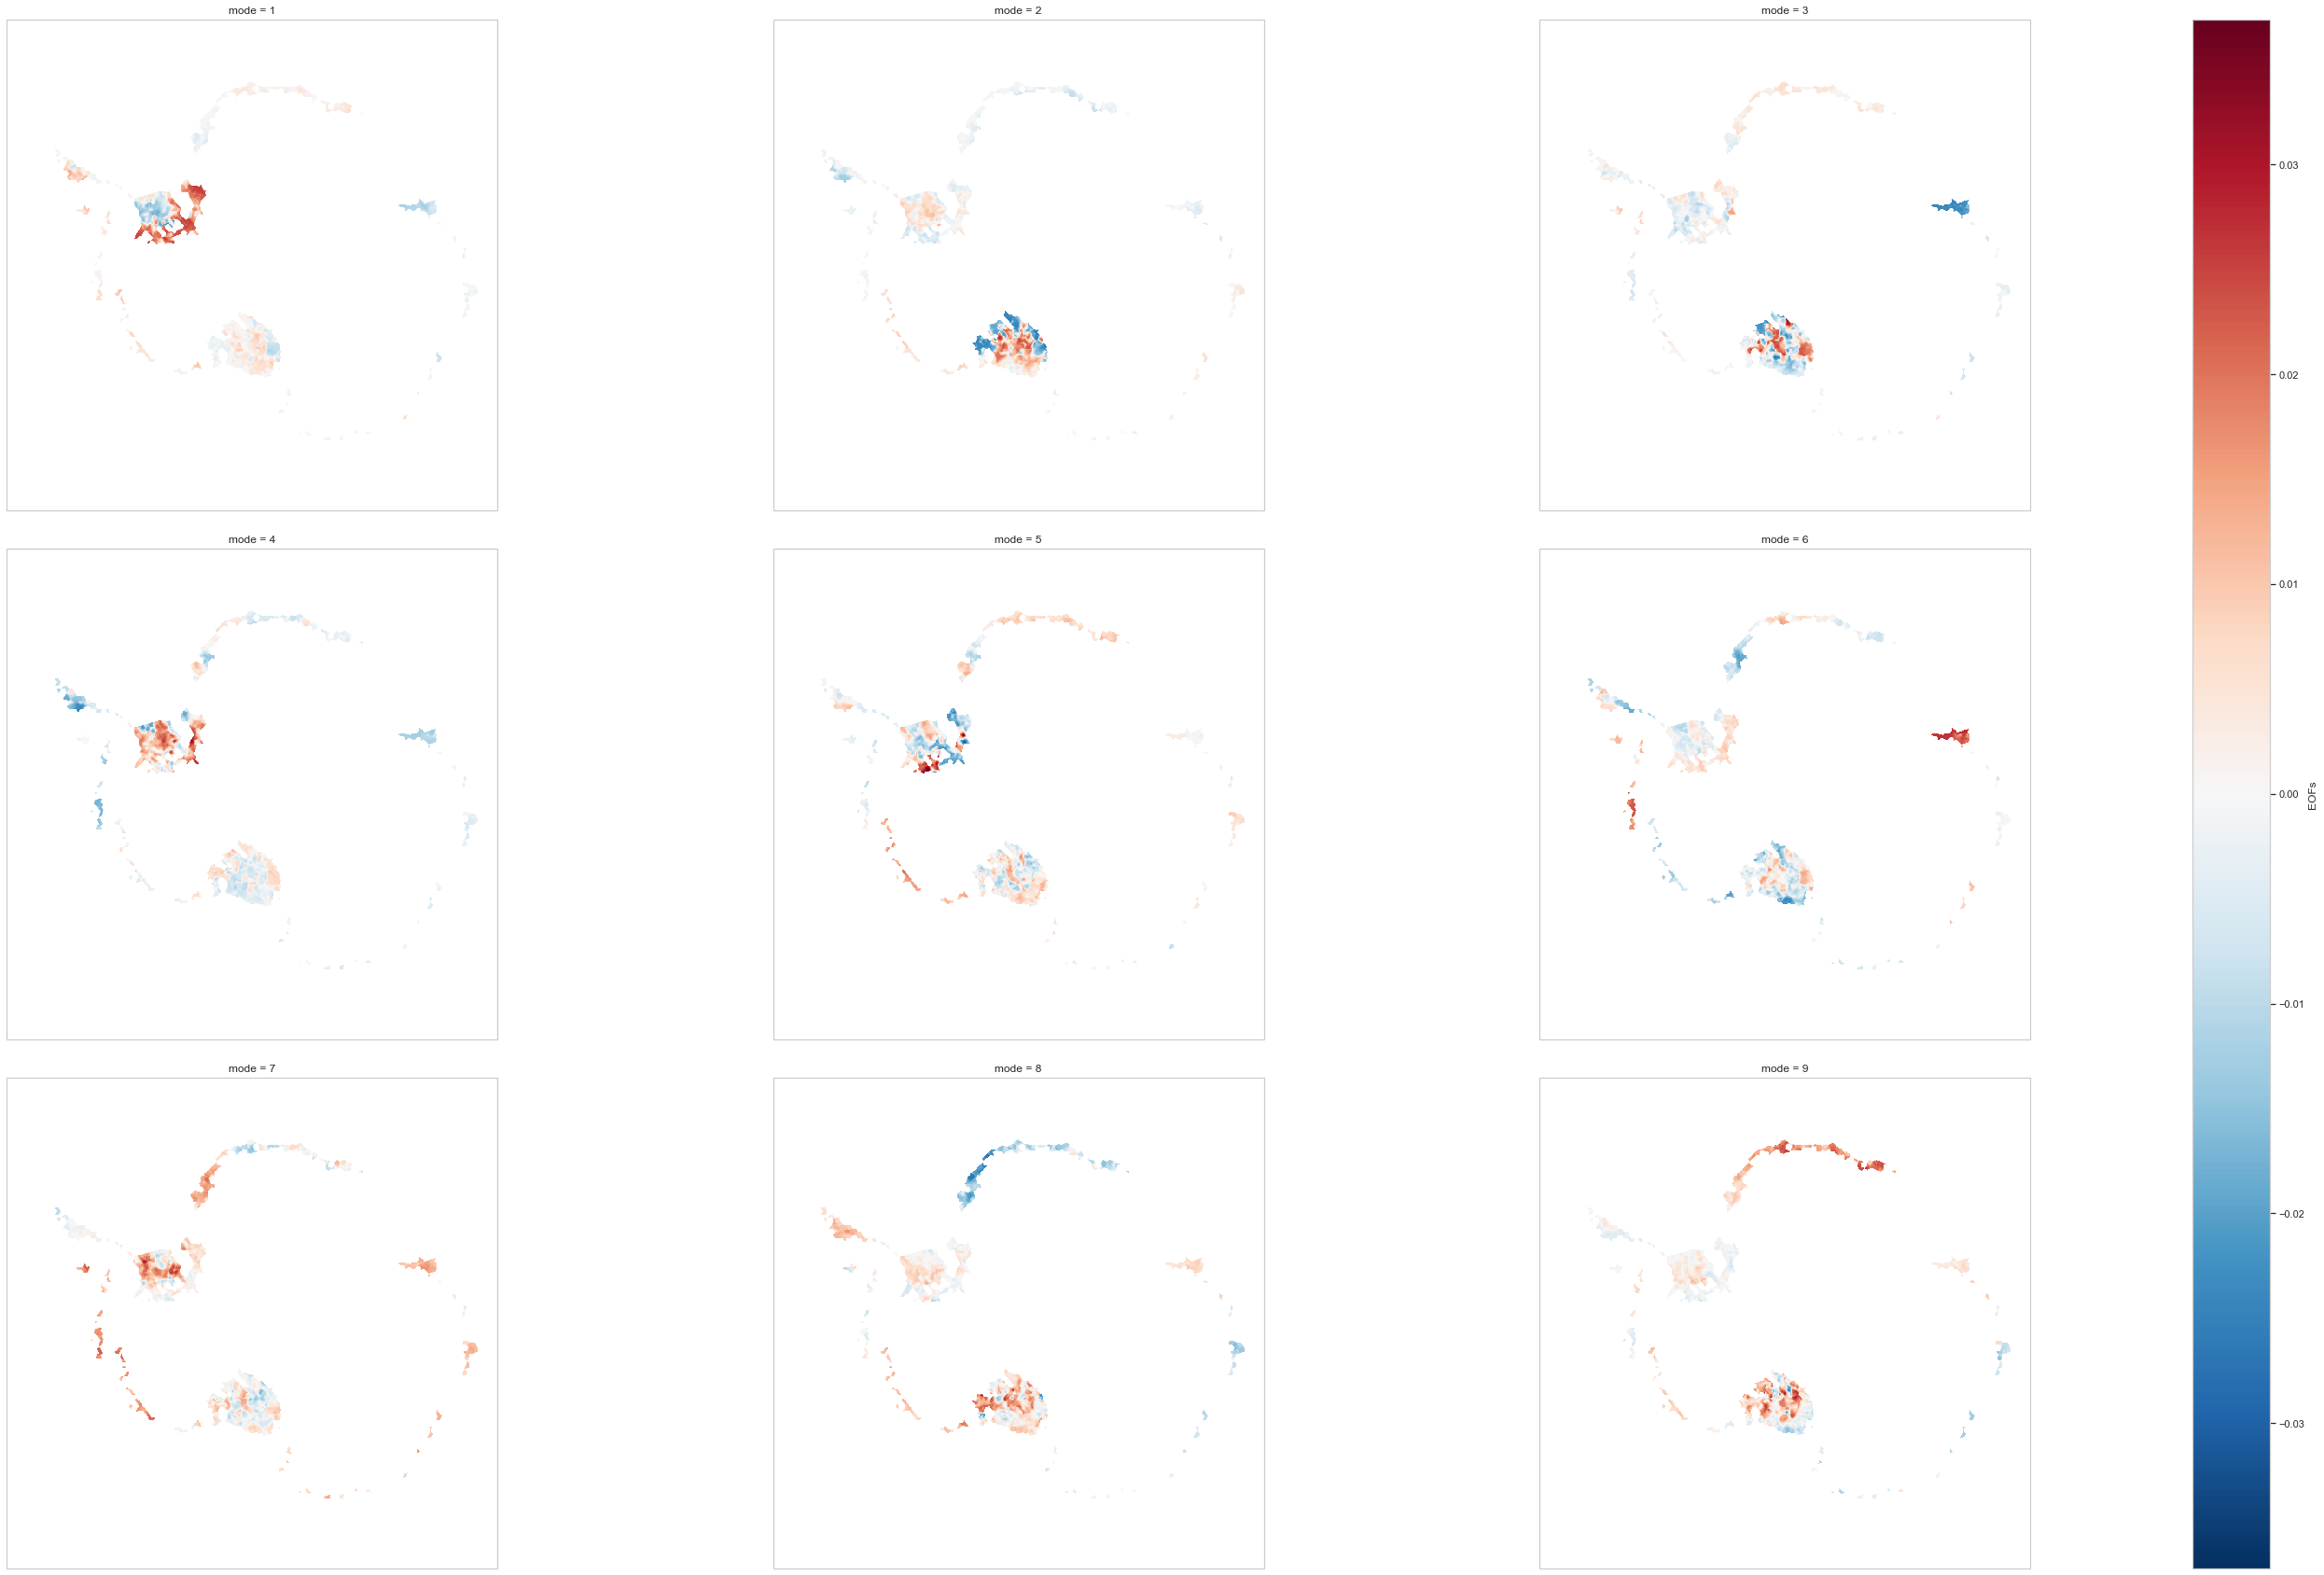

In [12]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:9].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=3,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

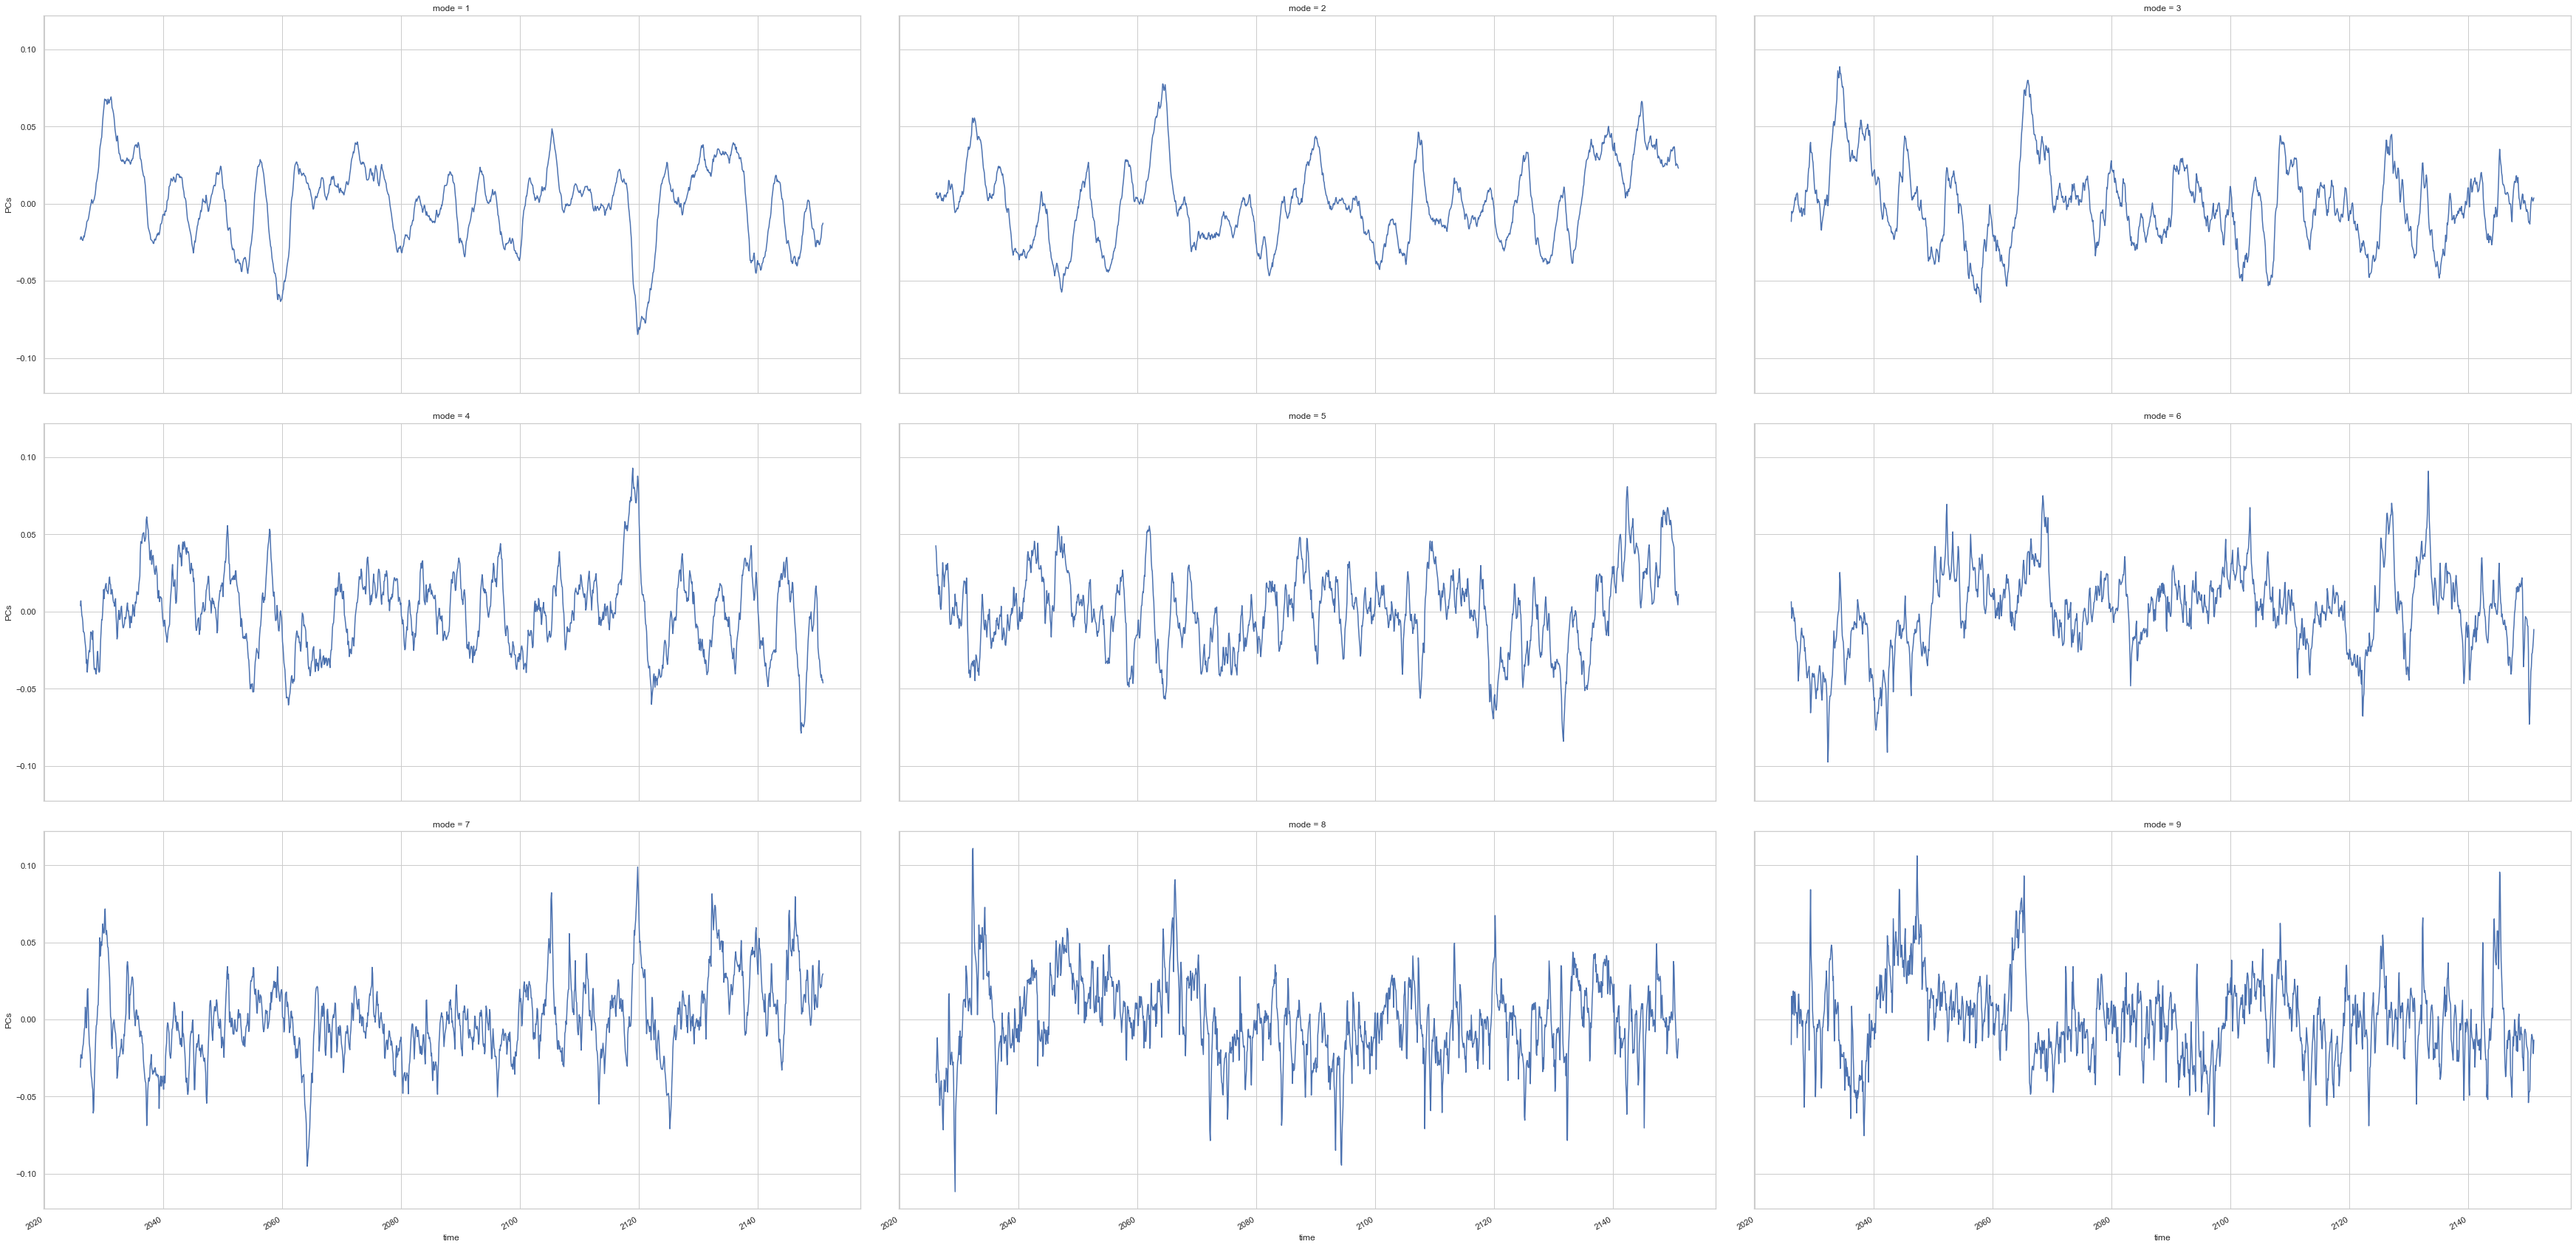

In [13]:
fg = pcs[:,0:9].plot(aspect=2,size=8,col="mode",col_wrap=3)

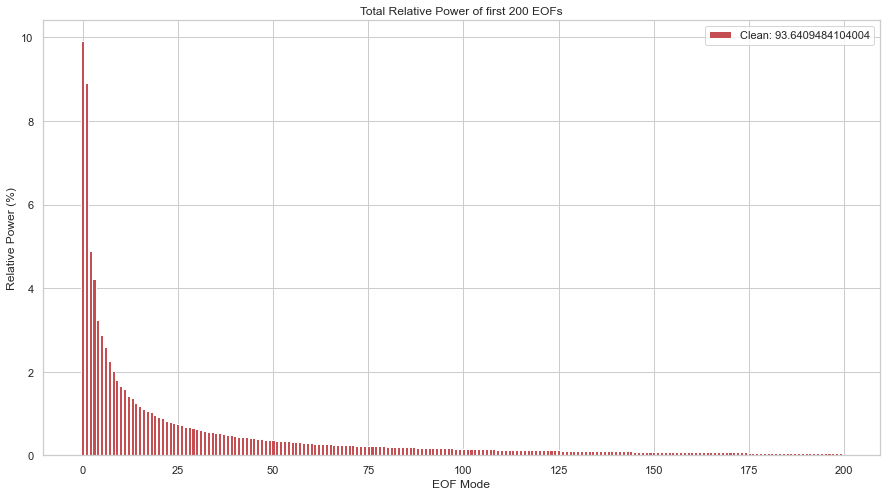

In [14]:
# Figure: Relative power of m EOFs
m = 200

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='r', 
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

## Fourier Phase Randomization

In [15]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

calculated ifft for realization 0, mode: 0
calculated ifft for realization 0, mode: 1
calculated ifft for realization 0, mode: 2
calculated ifft for realization 0, mode: 3
calculated ifft for realization 0, mode: 4
calculated ifft for realization 0, mode: 5
calculated ifft for realization 0, mode: 6
calculated ifft for realization 0, mode: 7
calculated ifft for realization 0, mode: 8
calculated ifft for realization 0, mode: 9
calculated ifft for realization 0, mode: 10
calculated ifft for realization 0, mode: 11
calculated ifft for realization 0, mode: 12
calculated ifft for realization 0, mode: 13
calculated ifft for realization 0, mode: 14
calculated ifft for realization 0, mode: 15
calculated ifft for realization 0, mode: 16
calculated ifft for realization 0, mode: 17
calculated ifft for realization 0, mode: 18
calculated ifft for realization 0, mode: 19
calculated ifft for realization 0, mode: 20
calculated ifft for realization 0, mode: 21
calculated ifft for realization 0, mode: 2

calculated ifft for realization 0, mode: 529
calculated ifft for realization 0, mode: 530
calculated ifft for realization 0, mode: 531
calculated ifft for realization 0, mode: 532
calculated ifft for realization 0, mode: 533
calculated ifft for realization 0, mode: 534
calculated ifft for realization 0, mode: 535
calculated ifft for realization 0, mode: 536
calculated ifft for realization 0, mode: 537
calculated ifft for realization 0, mode: 538
calculated ifft for realization 0, mode: 539
calculated ifft for realization 0, mode: 540
calculated ifft for realization 0, mode: 541
calculated ifft for realization 0, mode: 542
calculated ifft for realization 0, mode: 543
calculated ifft for realization 0, mode: 544
calculated ifft for realization 0, mode: 545
calculated ifft for realization 0, mode: 546
calculated ifft for realization 0, mode: 547
calculated ifft for realization 0, mode: 548
calculated ifft for realization 0, mode: 549
calculated ifft for realization 0, mode: 550
calculated

calculated ifft for realization 0, mode: 1122
calculated ifft for realization 0, mode: 1123
calculated ifft for realization 0, mode: 1124
calculated ifft for realization 0, mode: 1125
calculated ifft for realization 0, mode: 1126
calculated ifft for realization 0, mode: 1127
calculated ifft for realization 0, mode: 1128
calculated ifft for realization 0, mode: 1129
calculated ifft for realization 0, mode: 1130
calculated ifft for realization 0, mode: 1131
calculated ifft for realization 0, mode: 1132
calculated ifft for realization 0, mode: 1133
calculated ifft for realization 0, mode: 1134
calculated ifft for realization 0, mode: 1135
calculated ifft for realization 0, mode: 1136
calculated ifft for realization 0, mode: 1137
calculated ifft for realization 0, mode: 1138
calculated ifft for realization 0, mode: 1139
calculated ifft for realization 0, mode: 1140
calculated ifft for realization 0, mode: 1141
calculated ifft for realization 0, mode: 1142
calculated ifft for realization 0,

calculated ifft for realization 1, mode: 229
calculated ifft for realization 1, mode: 230
calculated ifft for realization 1, mode: 231
calculated ifft for realization 1, mode: 232
calculated ifft for realization 1, mode: 233
calculated ifft for realization 1, mode: 234
calculated ifft for realization 1, mode: 235
calculated ifft for realization 1, mode: 236
calculated ifft for realization 1, mode: 237
calculated ifft for realization 1, mode: 238
calculated ifft for realization 1, mode: 239
calculated ifft for realization 1, mode: 240
calculated ifft for realization 1, mode: 241
calculated ifft for realization 1, mode: 242
calculated ifft for realization 1, mode: 243
calculated ifft for realization 1, mode: 244
calculated ifft for realization 1, mode: 245
calculated ifft for realization 1, mode: 246
calculated ifft for realization 1, mode: 247
calculated ifft for realization 1, mode: 248
calculated ifft for realization 1, mode: 249
calculated ifft for realization 1, mode: 250
calculated

calculated ifft for realization 1, mode: 844
calculated ifft for realization 1, mode: 845
calculated ifft for realization 1, mode: 846
calculated ifft for realization 1, mode: 847
calculated ifft for realization 1, mode: 848
calculated ifft for realization 1, mode: 849
calculated ifft for realization 1, mode: 850
calculated ifft for realization 1, mode: 851
calculated ifft for realization 1, mode: 852
calculated ifft for realization 1, mode: 853
calculated ifft for realization 1, mode: 854
calculated ifft for realization 1, mode: 855
calculated ifft for realization 1, mode: 856
calculated ifft for realization 1, mode: 857
calculated ifft for realization 1, mode: 858
calculated ifft for realization 1, mode: 859
calculated ifft for realization 1, mode: 860
calculated ifft for realization 1, mode: 861
calculated ifft for realization 1, mode: 862
calculated ifft for realization 1, mode: 863
calculated ifft for realization 1, mode: 864
calculated ifft for realization 1, mode: 865
calculated

calculated ifft for realization 1, mode: 1462
calculated ifft for realization 1, mode: 1463
calculated ifft for realization 1, mode: 1464
calculated ifft for realization 1, mode: 1465
calculated ifft for realization 1, mode: 1466
calculated ifft for realization 1, mode: 1467
calculated ifft for realization 1, mode: 1468
calculated ifft for realization 1, mode: 1469
calculated ifft for realization 1, mode: 1470
calculated ifft for realization 1, mode: 1471
calculated ifft for realization 1, mode: 1472
calculated ifft for realization 1, mode: 1473
calculated ifft for realization 1, mode: 1474
calculated ifft for realization 1, mode: 1475
calculated ifft for realization 1, mode: 1476
calculated ifft for realization 1, mode: 1477
calculated ifft for realization 1, mode: 1478
calculated ifft for realization 1, mode: 1479
calculated ifft for realization 1, mode: 1480
calculated ifft for realization 1, mode: 1481
calculated ifft for realization 1, mode: 1482
calculated ifft for realization 1,

calculated ifft for realization 2, mode: 562
calculated ifft for realization 2, mode: 563
calculated ifft for realization 2, mode: 564
calculated ifft for realization 2, mode: 565
calculated ifft for realization 2, mode: 566
calculated ifft for realization 2, mode: 567
calculated ifft for realization 2, mode: 568
calculated ifft for realization 2, mode: 569
calculated ifft for realization 2, mode: 570
calculated ifft for realization 2, mode: 571
calculated ifft for realization 2, mode: 572
calculated ifft for realization 2, mode: 573
calculated ifft for realization 2, mode: 574
calculated ifft for realization 2, mode: 575
calculated ifft for realization 2, mode: 576
calculated ifft for realization 2, mode: 577
calculated ifft for realization 2, mode: 578
calculated ifft for realization 2, mode: 579
calculated ifft for realization 2, mode: 580
calculated ifft for realization 2, mode: 581
calculated ifft for realization 2, mode: 582
calculated ifft for realization 2, mode: 583
calculated

calculated ifft for realization 2, mode: 1176
calculated ifft for realization 2, mode: 1177
calculated ifft for realization 2, mode: 1178
calculated ifft for realization 2, mode: 1179
calculated ifft for realization 2, mode: 1180
calculated ifft for realization 2, mode: 1181
calculated ifft for realization 2, mode: 1182
calculated ifft for realization 2, mode: 1183
calculated ifft for realization 2, mode: 1184
calculated ifft for realization 2, mode: 1185
calculated ifft for realization 2, mode: 1186
calculated ifft for realization 2, mode: 1187
calculated ifft for realization 2, mode: 1188
calculated ifft for realization 2, mode: 1189
calculated ifft for realization 2, mode: 1190
calculated ifft for realization 2, mode: 1191
calculated ifft for realization 2, mode: 1192
calculated ifft for realization 2, mode: 1193
calculated ifft for realization 2, mode: 1194
calculated ifft for realization 2, mode: 1195
calculated ifft for realization 2, mode: 1196
calculated ifft for realization 2,

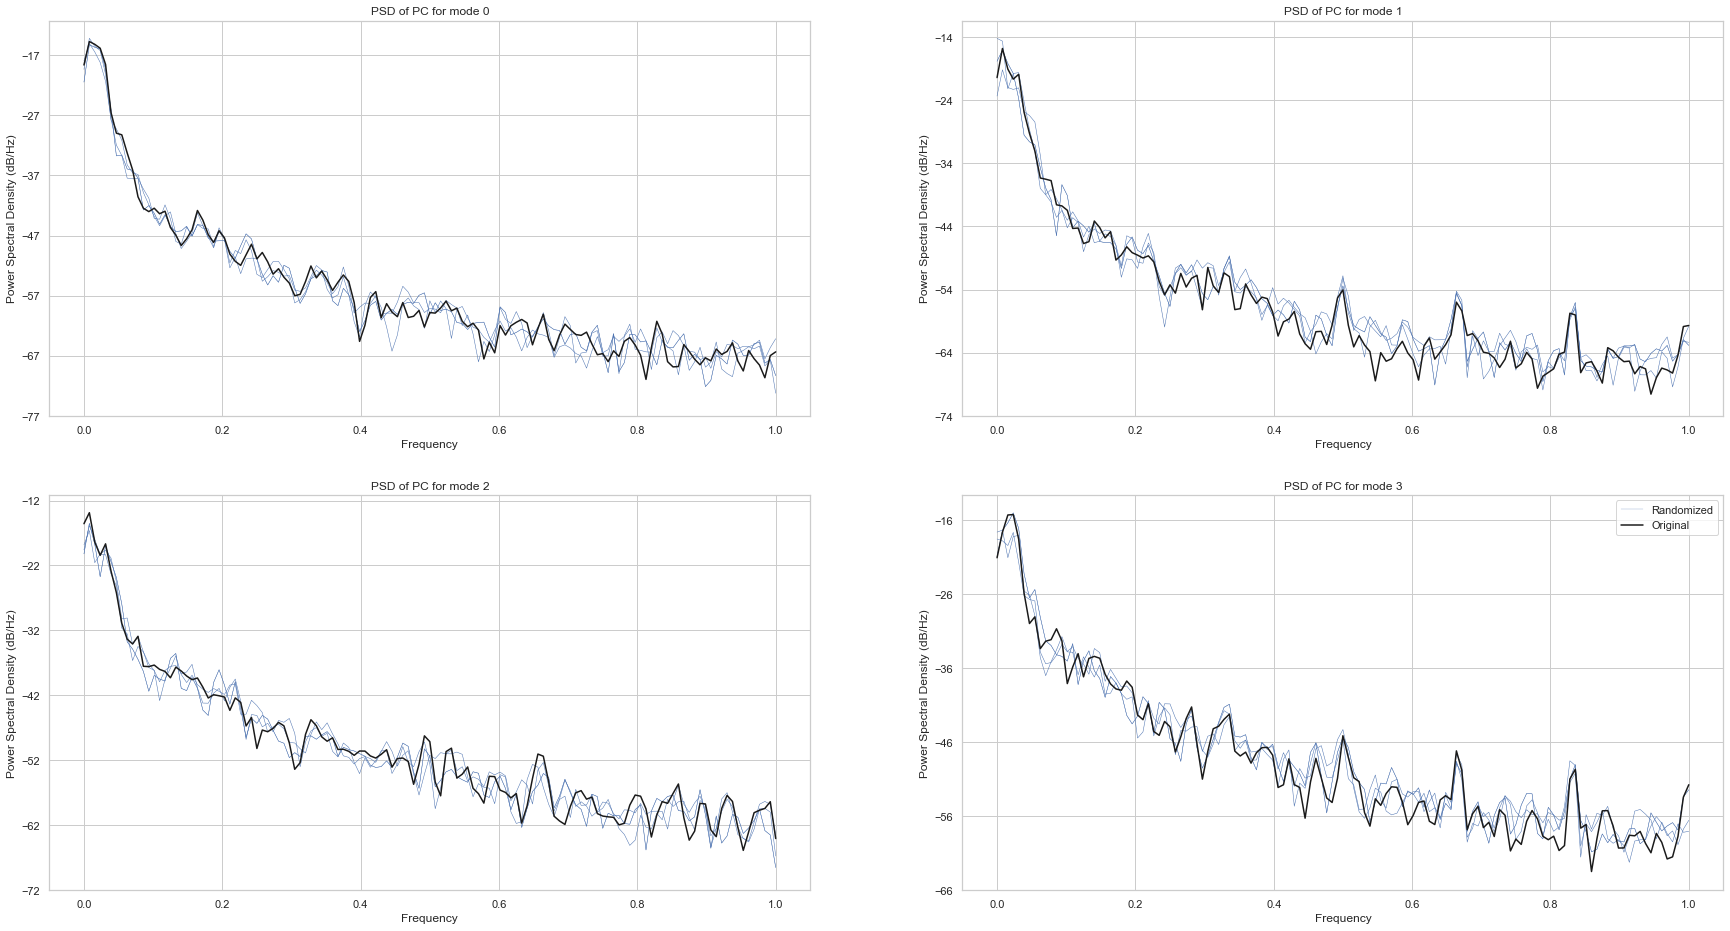

In [16]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,3):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

## Helper Functions

In [17]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [18]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [19]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [20]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Generator

In [21]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"flux_reconstr_std_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2


In [22]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_2.nc')
flux_reconstr2 = flux_reconstr2.__xarray_dataarray_variable__

In [23]:
basins = np.array((34,55,114,103,104,105))

In [24]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_{}".format(basin))
    del orig, rec0, rec1, rec2
    gc.collect()

In [25]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_105")

In [26]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)
rec1_34_ts = time_series(rec1_34)
rec2_34_ts = time_series(rec2_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)
rec1_55_ts = time_series(rec1_55)
rec2_55_ts = time_series(rec2_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)
rec1_114_ts = time_series(rec1_114)
rec2_114_ts = time_series(rec2_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)
rec1_103_ts = time_series(rec1_103)
rec2_103_ts = time_series(rec2_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)
rec1_104_ts = time_series(rec1_104)
rec2_104_ts = time_series(rec2_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)
rec1_105_ts = time_series(rec1_105)
rec2_105_ts = time_series(rec2_105)

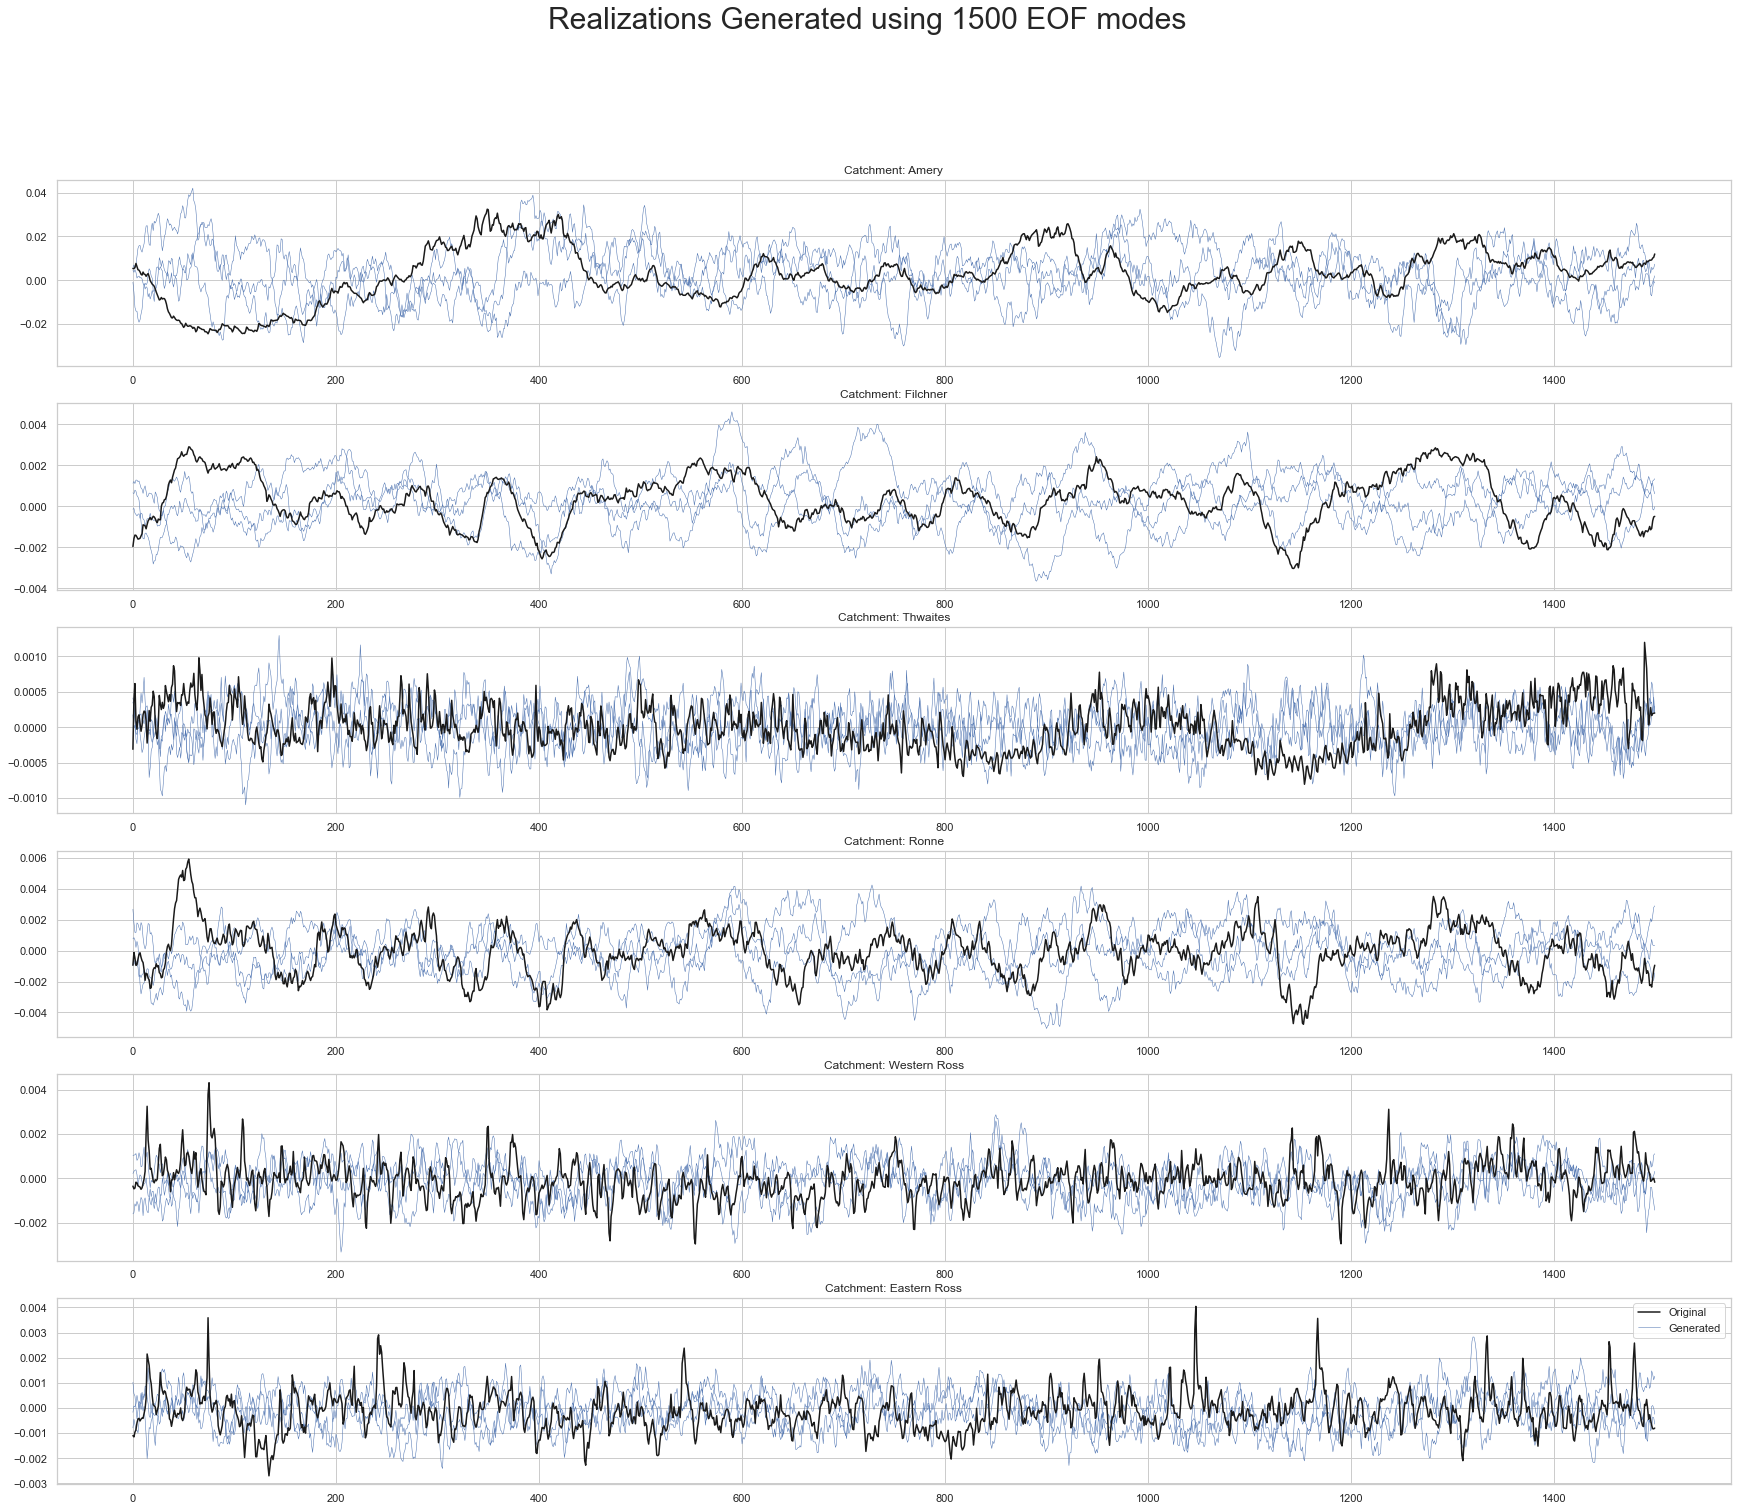

In [27]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

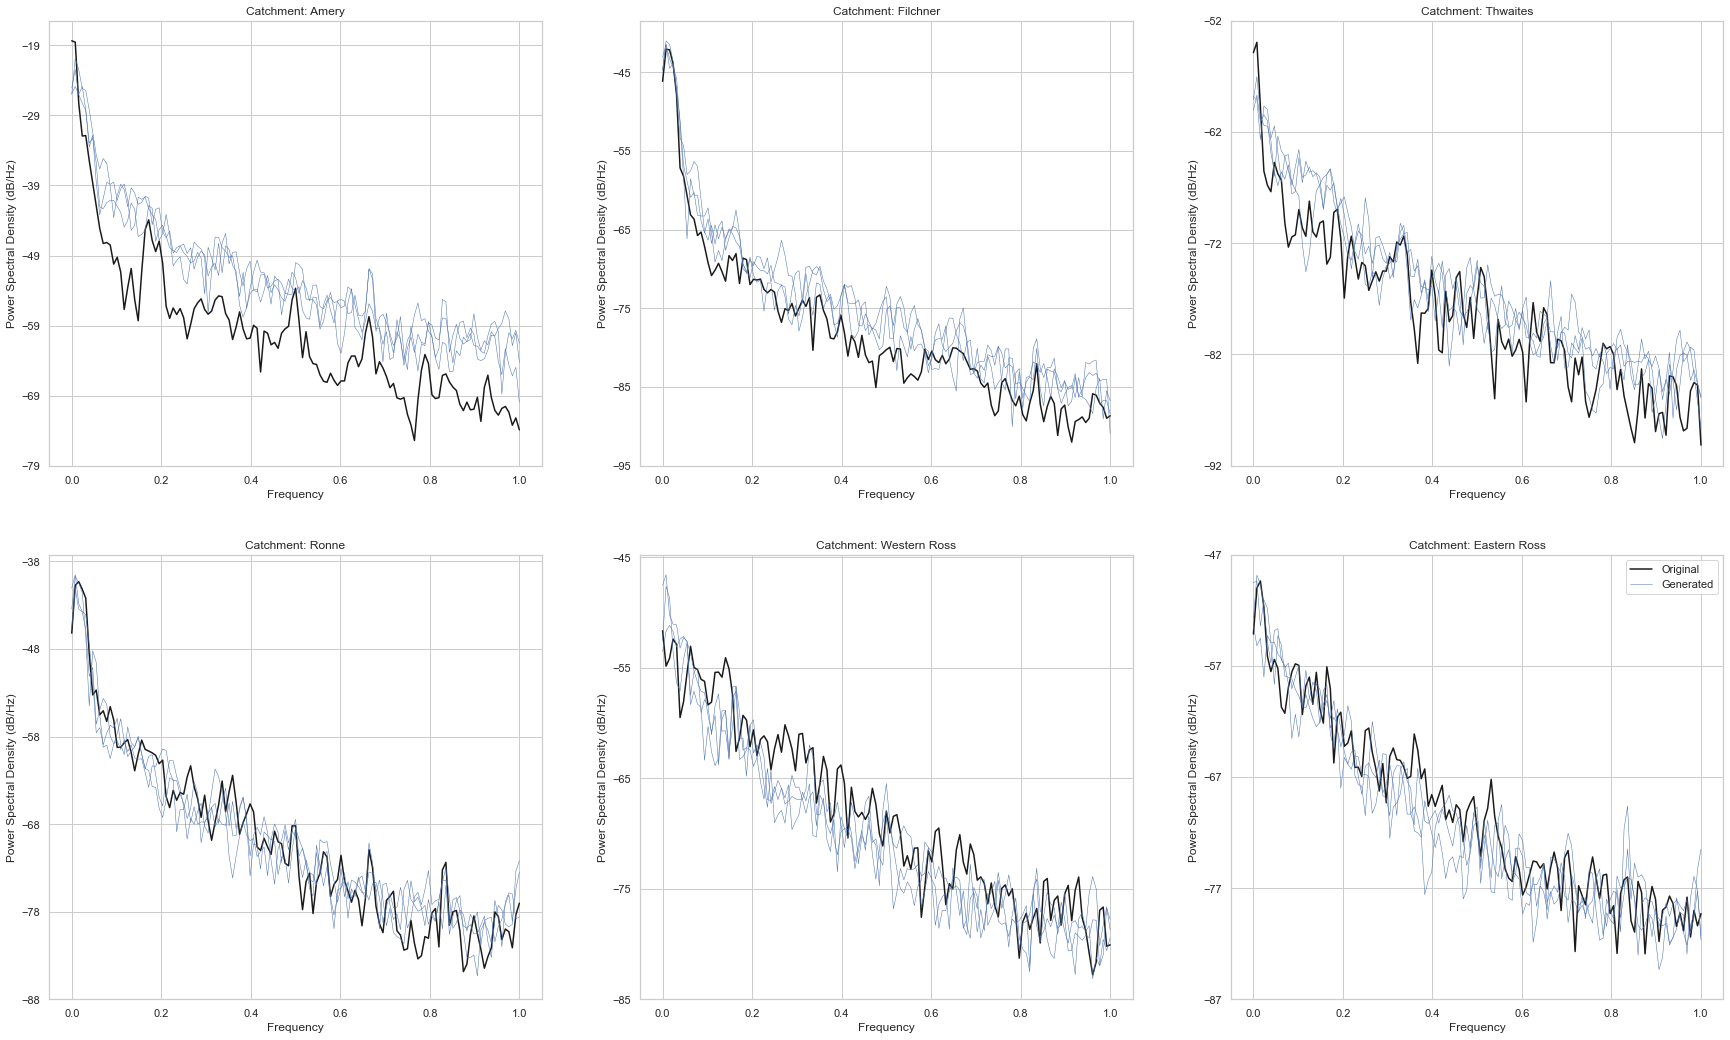

In [31]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].psd(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].psd(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].psd(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].psd(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].psd(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].psd(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()